In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy.stats import qmc  # For initial design
import matplotlib.pyplot as plt

# 🔹 1. Generate an Initial Latin Hypercube Design (LHD) using SciPy
num_factors = 2
num_trials = 15 # Adjust this value based on team decision

sampler = qmc.LatinHypercube(d=num_factors, optimization="random-cd")  # Improved LHS
design = sampler.random(n=num_trials)  # Generate samples

# Scale design to range [-1, 1]
design = 2 * design - 1
df = pd.DataFrame(design, columns=[f'Factor_{i+1}' for i in range(num_factors)])

# 🔹 2. Define a regression model for I-optimality
X = np.column_stack([df, df**2, np.prod(df, axis=1)])  # Quadratic terms
X = sm.add_constant(X)  # Add intercept
y = np.random.rand(len(df))  # Dummy response variable (not used in optimization)
model = sm.OLS(y, X).fit()  # Fit model structure

# 🔹 3. Define the I-optimality criterion (Minimize Average Prediction Variance)
def d_optimality(x):
    X_new = np.column_stack([x.reshape(-1, num_factors), x.reshape(-1, num_factors)**2, 
                             np.prod(x.reshape(-1, num_factors), axis=1)])
    X_new = sm.add_constant(X_new)  # Add intercept
    return -np.linalg.det(X_new.T @ X_new)  # Maximize determinant

opt_result = minimize(d_optimality, df.to_numpy().flatten(), method='L-BFGS-B', 
                      bounds=[(-1, 1)] * df.size)

# 🔹 5. Reshape the Optimized Design
optimal_design = opt_result.x.reshape(-1, num_factors)
optimal_df = pd.DataFrame(optimal_design, columns=[f'Factor_{i+1}' for i in range(num_factors)])

# 🔹 6. Scale to Real-World Ranges
factor_ranges = {
    "Factor_1": (20, 55),  # Water flow rate in GPM
    "Factor_2": (10, 50),  # Steam pressure in psig
}

def scale_values(value, min_val, max_val):
    return (value + 1) * (max_val - min_val) / 2 + min_val

for i, (factor, (min_val, max_val)) in enumerate(factor_ranges.items()):
    optimal_df[factor] = scale_values(optimal_df[f'Factor_{i+1}'], min_val, max_val)

optimal_df = optimal_df[list(factor_ranges.keys())]

# 🔹 Rename for Clarity
optimal_df.rename(columns={"Factor_1": "Water Flow Rate", "Factor_2": "Steam Pressure"}, inplace=True)
optimal_df['Trial'] = optimal_df.index + 1
optimal_df.index = optimal_df['Trial']
optimal_df.pop('Trial')

optimal_df = optimal_df.round(1)

# 🔹 Print final scaled design
print("✅ D-Optimal Design Space:")
optimal_df

✅ D-Optimal Design Space:


,Water Flow Rate,Steam Pressure
Trial,,
1,55.0,31.5
2,20.0,50.0
3,55.0,50.0
4,40.5,50.0
5,35.8,28.8
6,43.5,10.0
7,55.0,31.5
8,20.0,10.0
9,20.0,10.0


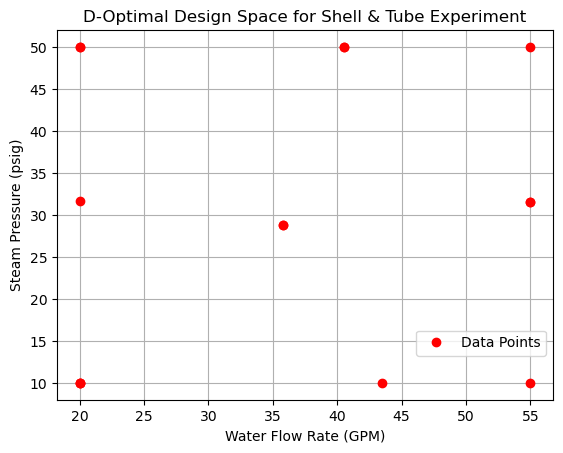

In [2]:
plt.figure()
plt.title("D-Optimal Design Space for Shell & Tube Experiment")
plt.plot(optimal_df['Water Flow Rate'],optimal_df['Steam Pressure'],'ro',label="Data Points")
plt.xlabel("Water Flow Rate (GPM)")
plt.ylabel("Steam Pressure (psig)")
plt.legend(loc="lower right", bbox_to_anchor=(1, 0.1))
plt.grid()
plt.show();